In [15]:
import sympy as sp

In [16]:
c0 = sp.Symbol("c_0", positive=True)
L = sp.Symbol("L", positive=True)
x = sp.Symbol("x", positive=True)
t = sp.Symbol("t", positive=True)
D = sp.Symbol("D", positive=True)
n = sp.Symbol("n", integer=True, positive=True)

c = sp.Function("c")(x, t)


In [17]:
integral = c0 * L * (1 - sp.sin(sp.pi * n)/(sp.pi * n))

f = 0
c_E_x = c0*(1-x/L)

integral = sp.integrate((f-c_E_x)*sp.sin(n*sp.pi*x/L), (x, 0, L))

Bn = 2/L * integral
infinite_sum = sp.Sum(Bn * sp.sin(n*sp.pi*x/L) * sp.exp(-D*(n*sp.pi/L)**2 * t), (n, 1, sp.oo))

c_expr = c0 * (1 - x/L) + infinite_sum
sp.Eq(c, c_expr)

Eq(c(x, t), c_0*(1 - x/L) + Sum(-2*c_0*exp(-pi**2*D*n**2*t/L**2)*sin(pi*n*x/L)/(pi*n), (n, 1, oo)))

In [18]:
flux_expr = -D*sp.diff(c_expr, x).subs(x, L)
flux_expr.simplify()

D*c_0*(2*Sum((-1)**n*exp(-pi**2*D*n**2*t/L**2), (n, 1, oo)) + 1)/L

In [19]:
K_H = sp.Symbol("K_H")
P_up = sp.Symbol("P_\mathrm{up}")
perm = sp.Symbol("\Phi")

flux_expr = flux_expr.subs(c0, K_H * P_up).simplify()
flux_expr = flux_expr.subs(D*K_H, perm).simplify()
flux_expr

P_\mathrm{up}*\Phi*(2*Sum((-1)**n*exp(-pi**2*D*n**2*t/L**2), (n, 1, oo)) + 1)/L

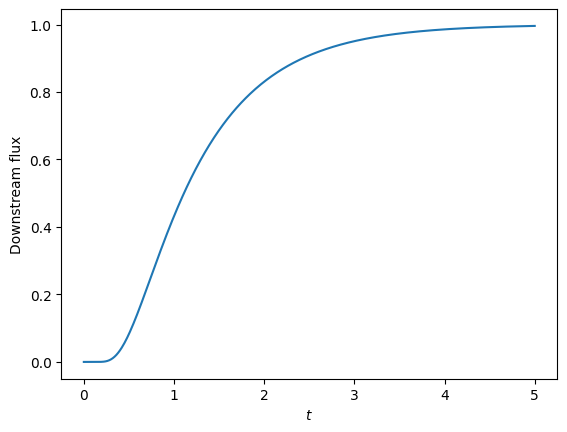

In [21]:
import numpy as np

P_up = 2
perm = 1
D = 0.5
L = 2

n_array = np.arange(1, 10000)[:, np.newaxis]
t_array = np.linspace(1e-8, 5, num=500)


flux = P_up * perm / L * (2* np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t_array), axis=0) + 1)
flux[0] = 0

import matplotlib.pyplot as plt
plt.plot(t_array, flux)
plt.xlabel(r"$t$")
plt.ylabel("Downstream flux")
plt.show()